# Project One - Global Terrorism Data
---
Jeff Shamp, John Kellogg, Grace Han - CUNY MSDS 620 - Spring 2021

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('./global_terror_data_proj_1.csv')

## Data

The data is from Global Terrorism Database (GTD) at the University of Maryland.
More information about the database [can be found here](!https://www.start.umd.edu/gtd/).
We will subset this database to only the necessary columns for this project as well as 
subset the start year to 1985 to make the data set more managable. 

### Country, Attack, Target

The first network we will analyze will be comprised of the country in which an act of terror takes place, the attach type (bombing, assassination, etc), and the target of the attack (government building, private citizens, etc). For this project the categorical information will the the target type. 

In [3]:
ter_df = df[["country_txt", "attacktype1_txt", "attacktype1", "targtype1_txt", "gname"]]
ter_df.head()

,country_txt,attacktype1_txt,attacktype1,targtype1_txt,gname
0,Sweden,Armed Assault,2,Government (General),Unknown
1,West Germany (FRG),Bombing/Explosion,3,Military,Unknown
2,France,Unknown,9,Police,Unknown
3,France,Unknown,9,Unknown,Unknown
4,France,Unknown,9,Unknown,Unknown


Some very basic information of the constructed network. 

In [4]:
G=nx.from_pandas_dataframe(ter_df, "country_txt", "attacktype1_txt", "targtype1_txt")
print (nx.info(G))

Name: 
Type: Graph
Number of nodes: 204
Number of edges: 1226
Average degree:  12.0196


This is a fairly large network so viewing it in matplotlib can burdensome. To visualize the network using pyvis please set the below variable `view_pyvis` to `True`. We will further subset the data to make a more viewbale network in following cells.

In [5]:
view_pyvis = False

In [6]:
from pyvis import network as net


if view_pyvis:
    N = net.Network(
                    bgcolor='#222222', font_color='white', 
                   notebook=True)
    N.barnes_hut()
    for n in G.nodes():
        N.add_node(n)
    for e in G.edges():
        N.add_edge(e[0], e[1])
    N.show('network_1.html')

Next we will subsest the data to active war zones in the middle east. 

In [7]:
us_involved = ["Syria", "Turkey", "Iraq","Jordan", 
               "Pakistan", "Afghanistan", "Israel", "Iran"]
ter_df_2 =  ter_df[ter_df.country_txt.isin(us_involved)]
G=nx.from_pandas_dataframe(ter_df_2,
                               "country_txt", 
                               "attacktype1_txt",
                               "targtype1_txt")
ter_df_2.head()

,country_txt,attacktype1_txt,attacktype1,targtype1_txt,gname
16,Israel,Bombing/Explosion,3,Government (General),Unknown
17,Israel,Bombing/Explosion,3,Private Citizens & Property,Unknown
268,Iran,Bombing/Explosion,3,Private Citizens & Property,Unknown
506,Iran,Bombing/Explosion,3,Government (General),Mujahedin-e Khalq (MEK)
979,Iran,Bombing/Explosion,3,Private Citizens & Property,Unknown


Again, to visual this network in pyvis simply change the variable to `True`

In [8]:
view_pyvis = False

In [9]:
if view_pyvis:
    N_2 = net.Network(bgcolor='#222222',
                      font_color='white',
                      height='1000px',
                      width='1000px',
                      notebook=True)
    N_2.barnes_hut()
    for n in H.nodes():
        N_2.add_node(n)
    for e in H.edges():
        N_2.add_edge(e[0], e[1])
    N_2.show('active_.html')

### Centrality and Target Type

Next we will look at a few centrality measures of the nodes. First, we will look at the eigenvector centrality, which is a measure of how well connected a node is to other nodes. 

In [10]:
node_1 = [node[0] for node in G.edges()]
node_2 = [node[1] for node in G.edges()]
attr_node = [G.get_edge_data(G.edges()[i][0],
                             G.edges()[i][1])['targtype1_txt']
            for i in range(len(G.edges()))]
data = zip(node_1, node_2, attr_node)
test_df = pd.DataFrame(data=data,
                      columns= ["source", "target", "type"])

In [11]:
eigen_G = nx.eigenvector_centrality_numpy(G)
eigen_sort = sorted(eigen_G.items(),
       key=lambda x:x[1],
       reverse=True)
eigen_df = pd.DataFrame(eigen_sort, 
                        columns=['node', 'eigen_central'])
eigen_df[['node', 'eigen_central']][:10]

,node,eigen_central
0,Pakistan,0.265242
1,Turkey,0.265242
2,Syria,0.265242
3,Iraq,0.265242
4,Afghanistan,0.265242
5,Facility/Infrastructure Attack,0.249362
6,Unknown,0.249362
7,Bombing/Explosion,0.249362
8,Assassination,0.249362
9,Armed Assault,0.249362


Here we see that the countries that are active participants in war are the most central, and that they are tied in eigenvector centrality. One possible exception being Pakistan. It seems the pourous border between Pakistan and Afghanistan might indicate more likely terrorist activities. We should note that this is not the case for all countries. Countries like, Iran, Israel, and Jordan are much further down the list, which makes sense given that they are _less_ involved in the current conflict.

In [12]:
eigen_list = eigen_df[eigen_df.eigen_central >= .24].node.to_list()
eigen_plot_df = test_df[test_df.source.isin(eigen_list)] 

If we filter the network for the most central nodes in this analysis and plot the counts of there respective target type category will see the following.

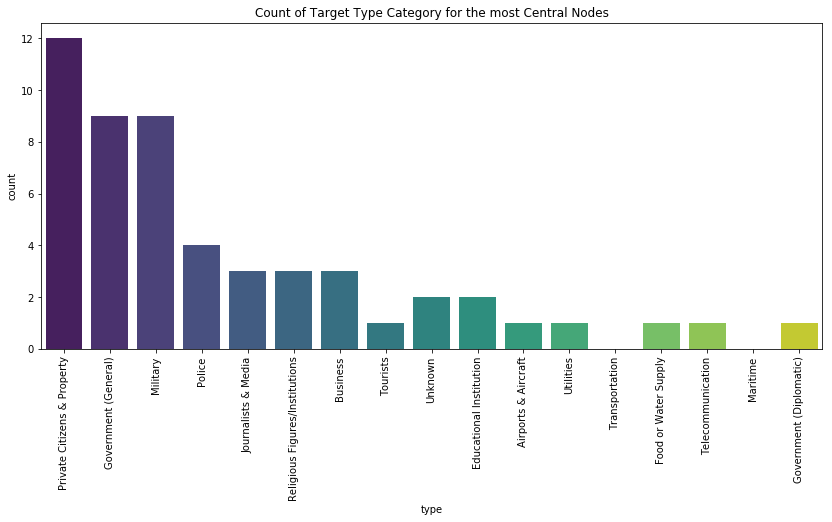

In [13]:
plt.figure(figsize=(14,6))
sns.countplot(data=eigen_plot_df, 
              x='type',
              palette='viridis',
              order=test_df.type.value_counts().index)
plt.xticks(rotation=90)
plt.title("Count of Target Type Category for the most Central Nodes")
plt.show()

Attacks against private citizens, the military, and the government make up the three most common target type. 

### Degree Centrality

We will run a similar analysis using degree centrality and compare the results.

In [14]:
degree_G = nx.degree_centrality(G)
degree_sort = sorted(degree_G.items(),
      key=lambda x:x[1], 
      reverse=True)
degree_df = pd.DataFrame(degree_sort, columns=['node', 'degree_central'])
degree_df[degree_df.node.isin(us_involved)]

,node,degree_central
0,Pakistan,0.5625
1,Turkey,0.5625
2,Syria,0.5625
3,Afghanistan,0.5625
4,Iraq,0.5625
5,Israel,0.5000
7,Iran,0.5000
16,Jordan,0.3750


In [15]:
degree_list = degree_df[degree_df.degree_central >= 0.50].node.to_list()
degree_plot_df = test_df[test_df.source.isin(degree_list)] 

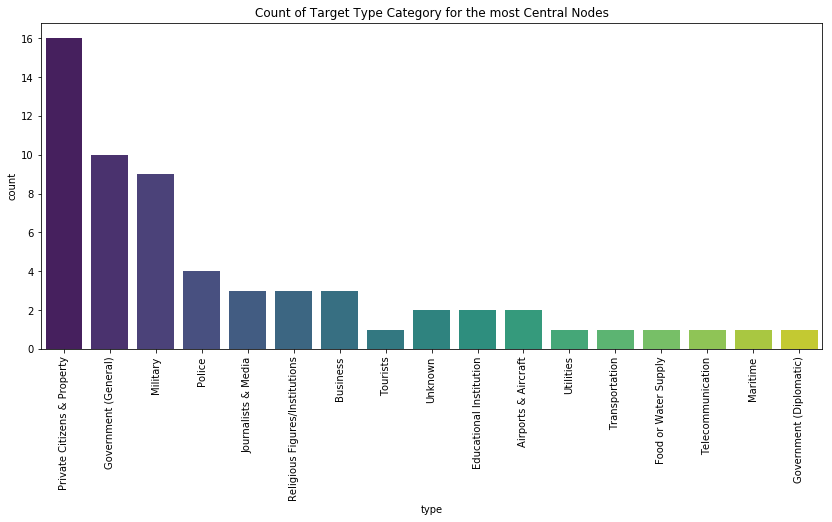

In [16]:
plt.figure(figsize=(14,6))
sns.countplot(data=degree_plot_df, 
              x='type',
              palette='viridis',
              order=test_df.type.value_counts().index)
plt.xticks(rotation=90)
plt.title("Count of Target Type Category for the most Central Nodes")
plt.show()

These two metrics; eigenvector centrality and degree centrality produce highly similar distributions of categorical counts. It seems as though this network is _too_ closed for a more meaningful comparison. 

## Country, Group, Target

We will now shift lenes on this and construct a different network where the nodes are countries and group that attacked that country. We will afix the same target type categorical to each node and run similar metrics.

In [17]:
ter_df.head()

,country_txt,attacktype1_txt,attacktype1,targtype1_txt,gname
0,Sweden,Armed Assault,2,Government (General),Unknown
1,West Germany (FRG),Bombing/Explosion,3,Military,Unknown
2,France,Unknown,9,Police,Unknown
3,France,Unknown,9,Unknown,Unknown
4,France,Unknown,9,Unknown,Unknown


In [18]:
H=nx.from_pandas_dataframe(ter_df, "country_txt", "gname", "targtype1_txt")
print (nx.info(H))

Name: 
Type: Graph
Number of nodes: 3046
Number of edges: 4249
Average degree:   2.7899


To view the network in pyvis

In [19]:
view_pyvis = True

In [20]:
if view_pyvis:
    M = net.Network(
                    bgcolor='#222222', font_color='white', 
                   notebook=True)
    M.barnes_hut()
    for n in H.nodes():
        M.add_node(n)
    for e in H.edges():
        M.add_edge(e[0], e[1])
    M.show('network_2.html')

In [72]:
us_involved = ["Syria", "Turkey", "Iraq","Jordan", 
               "Pakistan", "Afghanistan", "Israel", "Iran"]
ter_df_2 =  ter_df[ter_df.country_txt.isin(us_involved)]
H=nx.from_pandas_dataframe(ter_df_2,
                               "country_txt", 
                               "gname",
                               "targtype1_txt")
ter_df_2.head()

,country_txt,attacktype1_txt,attacktype1,targtype1_txt,gname
16,Israel,Bombing/Explosion,3,Government (General),Unknown
17,Israel,Bombing/Explosion,3,Private Citizens & Property,Unknown
268,Iran,Bombing/Explosion,3,Private Citizens & Property,Unknown
506,Iran,Bombing/Explosion,3,Government (General),Mujahedin-e Khalq (MEK)
979,Iran,Bombing/Explosion,3,Private Citizens & Property,Unknown


In [73]:
node_1 = [node[0] for node in H.edges()]
node_2 = [node[1] for node in H.edges()]
attr_node = [H.get_edge_data(H.edges()[i][0],
                             H.edges()[i][1])['targtype1_txt']
            for i in range(len(H.edges()))]
data = zip(node_1, node_2, attr_node)
test_df_2 = pd.DataFrame(data=data,
                      columns= ["source", "target", "type"])

In [74]:
eigen_H = nx.eigenvector_centrality_numpy(H)
eigen_sort = sorted(eigen_H.items(),
       key=lambda x:x[1],
       reverse=True)
eigen_df = pd.DataFrame(eigen_sort, 
                        columns=['node', 'eigen_central'])
eigen_df[['node', 'eigen_central']][:10]

,node,eigen_central
0,Pakistan,0.643762
1,Iraq,0.190405
2,Afghanistan,0.134182
3,Turkey,0.109138
4,Muslim extremists,0.109030
5,Unknown,0.109030
6,Gunmen,0.100933
7,Syria,0.092835
8,Islamist extremists,0.090647
9,Militants,0.078482


In [24]:
eigen_list = eigen_df.node.to_list()[:5]
eigen_plot_df = test_df[test_df.source.isin(eigen_list)] 

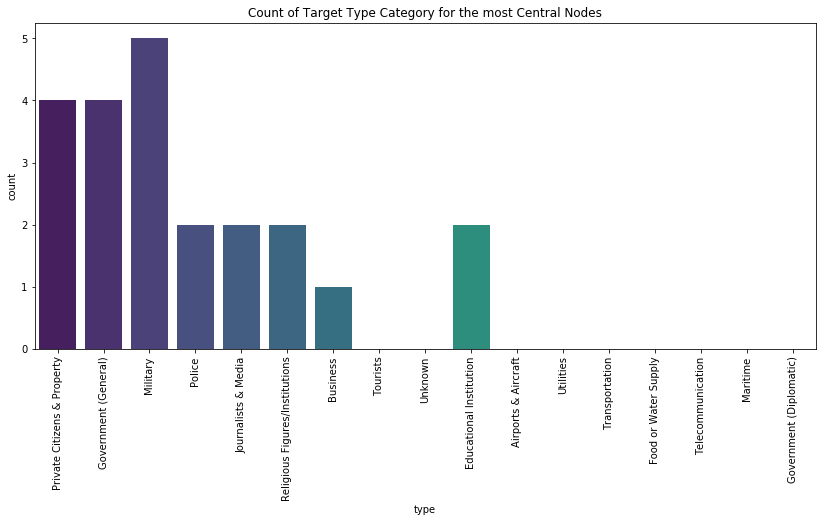

In [25]:
plt.figure(figsize=(14,6))
sns.countplot(data=eigen_plot_df, 
              x='type',
              palette='viridis',
              order=test_df.type.value_counts().index)
plt.xticks(rotation=90)
plt.title("Count of Target Type Category for the most Central Nodes")
plt.show()

In [26]:
degree_H = nx.degree_centrality(H)
degree_sort = sorted(degree_H.items(),
      key=lambda x:x[1], 
      reverse=True)
degree_df = pd.DataFrame(degree_sort, columns=['node', 'degree_central'])
degree_df[['node', 'degree_central']][:10]

,node,degree_central
0,Pakistan,0.306695
1,Iraq,0.213823
2,Syria,0.159827
3,Israel,0.144708
4,Turkey,0.136069
5,Afghanistan,0.092873
6,Iran,0.082073
7,Jordan,0.038877
8,Unknown,0.017279
9,Muslim extremists,0.017279


In [27]:
degree_list = degree_df.node.to_list()[:5]
degree_plot_df = test_df[test_df.source.isin(degree_list)] 

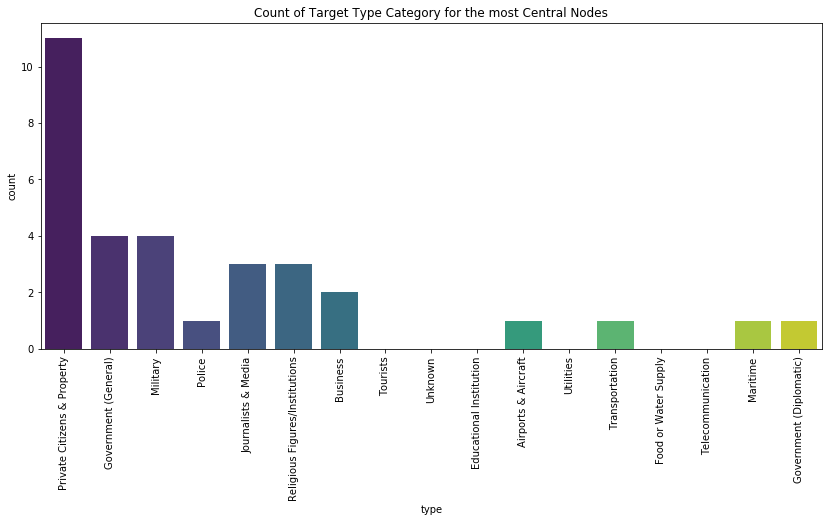

In [28]:
plt.figure(figsize=(14,6))
sns.countplot(data=degree_plot_df, 
              x='type',
              palette='viridis',
              order=test_df.type.value_counts().index)
plt.xticks(rotation=90)
plt.title("Count of Target Type Category for the most Central Nodes")
plt.show()

In [56]:
ter_df_sub =  ter_df[ter_df.country_txt.isin(us_involved)]
ter_df_sub['ID'] = np.arange(len(ter_df_sub))
ter_df_sub.head(20)

,country_txt,attacktype1_txt,attacktype1,targtype1_txt,gname,ID
16,Israel,Bombing/Explosion,3,Government (General),Unknown,0
17,Israel,Bombing/Explosion,3,Private Citizens & Property,Unknown,1
268,Iran,Bombing/Explosion,3,Private Citizens & Property,Unknown,2
506,Iran,Bombing/Explosion,3,Government (General),Mujahedin-e Khalq (MEK),3
979,Iran,Bombing/Explosion,3,Private Citizens & Property,Unknown,4
980,Israel,Bombing/Explosion,3,Private Citizens & Property,Unknown,5
986,Israel,Bombing/Explosion,3,Private Citizens & Property,Unknown,6
987,Israel,Bombing/Explosion,3,Private Citizens & Property,Unknown,7
988,Israel,Bombing/Explosion,3,Private Citizens & Property,Unknown,8
1613,Israel,Bombing/Explosion,3,Government (General),Unknown,9


,attacktype1,ID
16,3,0
17,3,1
268,3,2
506,3,3
979,3,4


['Israel',
 3,
 'Iran',
 'Pakistan',
 'Turkey',
 1,
 'Syria',
 7,
 2,
 9,
 4,
 6,
 'Afghanistan',
 8,
 'Iraq',
 5,
 'Jordan']

16        2
17        2
268       2
506       2
979       2
         ..
177096    2
177097    8
177101    8
177108    8
177109    2
Length: 66776, dtype: int8

ValueError: c of shape (66776,) not acceptable as a color sequence for x with size 17, y with size 17

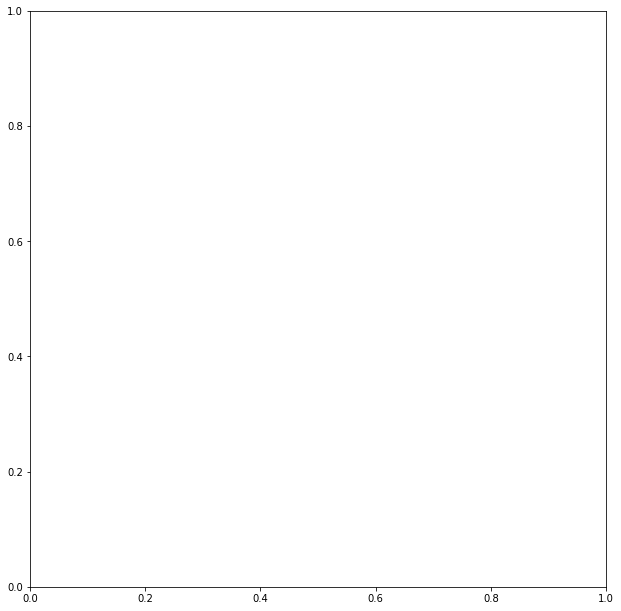

,country_txt,attacktype1_txt,attacktype1,targtype1_txt,gname,ID,catvalue
16,Israel,Bombing/Explosion,3,Government (General),Unknown,0,3
17,Israel,Bombing/Explosion,3,Private Citizens & Property,Unknown,1,3
268,Iran,Bombing/Explosion,3,Private Citizens & Property,Unknown,2,3
506,Iran,Bombing/Explosion,3,Government (General),Mujahedin-e Khalq (MEK),3,2
979,Iran,Bombing/Explosion,3,Private Citizens & Property,Unknown,4,1


In [67]:
target_org = df[['targtype1_txt', 'gname', 'weaptype1']]
target_org = target_org[target_org['gname']!= "Unknown"]
target_org.head()

,targtype1_txt,gname,weaptype1
15,Transportation,Tamils,6
18,Government (Diplomatic),Chukakuha (Middle Core Faction),6
19,Private Citizens & Property,Shining Path (SL),5
20,Government (General),Shining Path (SL),5
21,Private Citizens & Property,Shining Path (SL),5


In [68]:
G=nx.from_pandas_dataframe(target_org, "targtype1_txt", "gname", "weaptype1")
print (nx.info(G))

Name: 
Type: Graph
Number of nodes: 2872
Number of edges: 7722
Average degree:   5.3774


In [ ]:
view_pyvis = True
from pyvis import network as net
if view_pyvis:
    M = net.Network(
                    bgcolor='#222222', font_color='white', 
                   notebook=True)
    M.barnes_hut()
    for n in G.nodes():
        M.add_node(n)
    for e in G.edges():
        M.add_edge(e[0], e[1])
    M.show('target_org.html')

In [69]:
n=5
top_gname = target_org['gname'].value_counts()[:n].index.tolist()
target_org_small =  target_org[target_org.gname.isin(top_gname)]

target_org_small.count()
#ter_df_2 =  ter_df[ter_df.country_txt.isin(us_involved)]

targtype1_txt    27459
gname            27459
weaptype1        27459
dtype: int64

In [70]:
S=nx.from_pandas_dataframe(target_org_small, "targtype1_txt","gname")
print (nx.info(S))

Name: 
Type: Graph
Number of nodes: 26
Number of edges: 100
Average degree:   7.6923


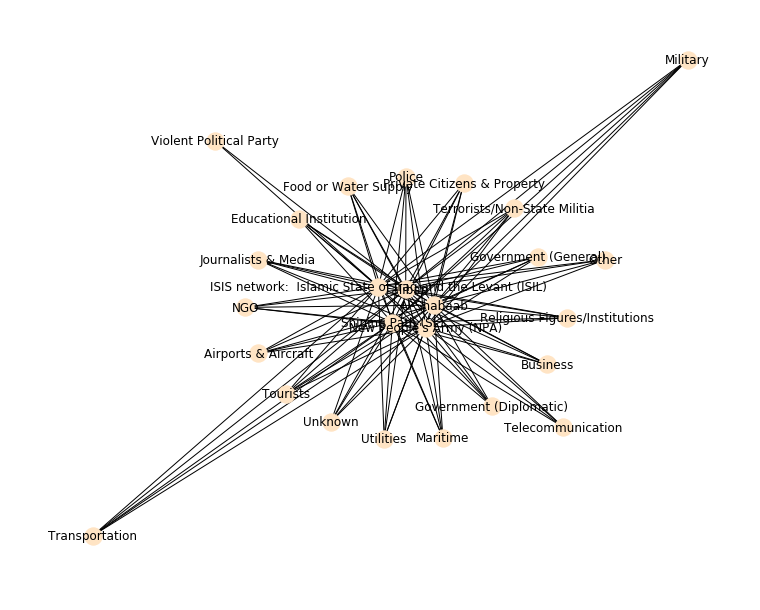

In [71]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)
nx.draw(S, node_color='bisque', with_labels=True)